Ce notebook contient toutes les étapes qui nous permettent de traiter les données et d'entrainer notre IA.

Importations

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

Definition de quelques fonctions utiles :

In [3]:
def load_images_from_folder(folder_path, target_size=None):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(folder_path, filename)
            image = Image.open(img_path)
            if target_size:
                image = image.resize(target_size)  # Redimensionner l'image si nécessaire
            image_array = np.array(image)  # Convertir l'image en tableau NumPy
            images.append(image_array)
            filenames.append(filename)
    return np.array(images), filenames

def normalize(images):
    s=images.shape
    images = images.astype("float32")/255
    images = images.reshape(s[0],s[1]*s[2]*s[3])
    return images

def denormalize(img):
    img = img.reshape(400,400,3)
    return img

def plotimage(img):
    img = denormalize(img)
    plt.imshow(img)
    plt.axis('off')  # Masquer les axes
    plt.show()



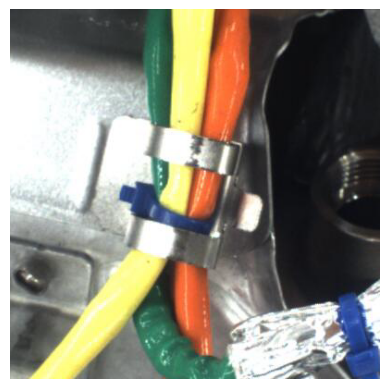

In [4]:
folder_path = '/home/jgayraud/Documents/MIC3/BE/engine_wiring/train/good'
target_size = (400, 400)  
images, filenames = load_images_from_folder(folder_path, target_size)

images = normalize(images)

plotimage(images[3,:])


Le code suivant est la classe permettant de créer cette IA avec  plusieurs fonctions

Definition du modèle :

In [6]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(400*400*3, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 20)
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(20, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500,400*400*3),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Definition du loader ( la database qui va servir à s'entrainer en prenant en compte le bash (nombre d'itérations avant update)) et de certains hyperparamètres

In [9]:
model = AE()
BashSize = 32


loss_function = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)


images_tensor = torch.tensor(images, dtype=torch.float32)

dataset = TensorDataset(images_tensor)  


loader = torch.utils.data.DataLoader(dataset = images_tensor,
                                     batch_size = BashSize,
                                     shuffle = True)

Entrainement du modèle :

In [10]:
num_epochs = 4
losses = []

for epoch in range(num_epochs):
    for batch in loader:
        # Séparer les données d'entrée et les cibles (ici, les mêmes images)
        inputs = batch[0]
        targets = inputs
        # Remettre les gradients à zéro
        optimizer.zero_grad()

        # Passer les données dans le modèle
        outputs = model(inputs)

        # Calculer la perte
        loss = loss_function(outputs, targets)

        # Rétropropagation et mise à jour des poids
        loss.backward()
        optimizer.step()
        losses.append(loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Entraînement terminé.")



Epoch [1/4], Loss: 0.1576
Epoch [2/4], Loss: 0.1575
Epoch [3/4], Loss: 0.1681
Epoch [4/4], Loss: 0.2656
Entraînement terminé.


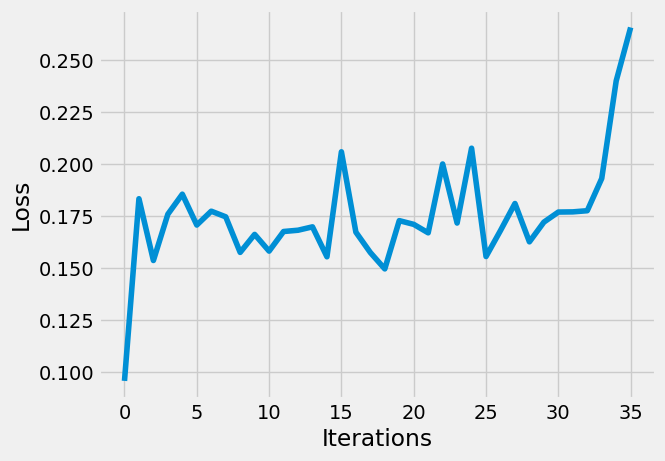

In [11]:
losses_np = [loss.detach().numpy() for loss in losses]

# Définir le style du graphique
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Tracer les 100 dernières valeurs de perte
plt.plot(losses_np[-100:])

# Afficher le graphique
plt.show()

Nous avons essayé dans un premier temps 10 époques mais nous remarquons une augmentation sygnificative du loss au bout de 5 époques. Nous devons modifier les hyperparamètres pour avoir un meilleur modèle.

Passage d'une image dans le modèle, pour vérifier la robustesse du modèle :

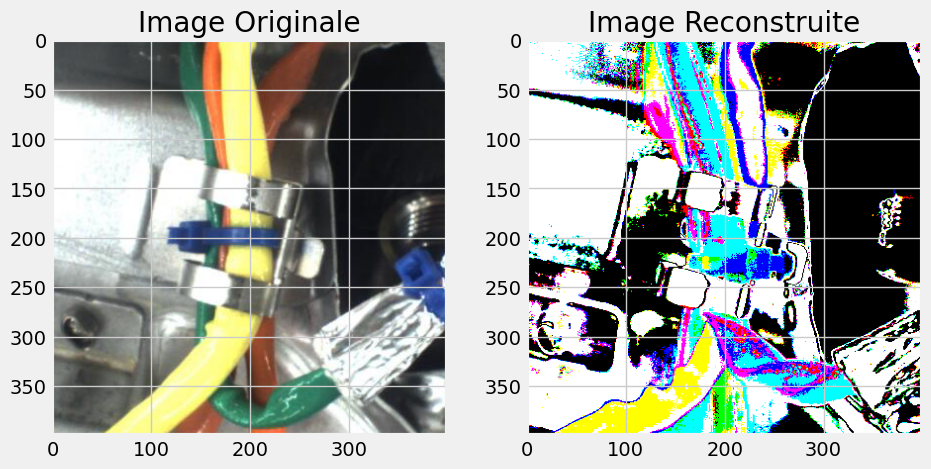

In [17]:
# Convertir l'image en tenseur
number = 1

image_tensor = torch.tensor(images[number, :], dtype=torch.float32).view(1, -1)

# Passer l'image à travers le modèle pour obtenir la reconstruction
model.eval()  # Passer le modèle en mode évaluation
with torch.no_grad():
    reconstructed_image = model(image_tensor)

# Remettre en forme et afficher l'image originale et la reconstruction
original_image = images[number, :].reshape(400, 400, 3)
reconstructed_image = reconstructed_image.view(400, 400, 3).numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Image Originale')
plt.imshow(original_image)

plt.subplot(1, 2, 2)
plt.title('Image Reconstruite')
plt.imshow(reconstructed_image)

plt.show()

Pour l'instant, nous avons une image de sortie similaire peu importe l'image de départ. On suppose que le modèle est mal entrainé (Trop d'époques ou autres), ou une erreur dans lecode